The generated sketches look nothing like hand drawn sketches, which are high contrast black lines with no shading. They also still include shadows and many have some background colour.

Need to do some work to prepare trhe sketch dataset closer to the target dataset.

U2-NET can remove much of the backgound and shadows.

HED instead of DexiNed may be better for simpler edge detection.

May need to do some bulk hand tuning of images to improve dataset.

Using a pretrained U2Net to remove backgrounds

https://github.com/shreyas-bk/U-2-Net/blob/master/u2net_test.py

https://colab.research.google.com/github/shreyas-bk/U-2-Net-Demo/blob/master/DEMOS/U_2_Netp_Demonstration_Colab.ipynb#scrollTo=eWxv7eDJiq5b

Uses U2NETP # small version u2net 4.7 MB

The snpachat filter blog poerforms HED then Canny edge detection ion the output of HED.

In [122]:
from IPython import get_ipython
get_ipython().run_line_magic('reload_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')
get_ipython().run_line_magic('matplotlib', 'inline')

In [107]:
import pathlib
import os
import zipfile
import shutil
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image as Img
import cv2
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
from skimage import feature

PATH = pathlib.Path.cwd()
DATA_DIR = PATH.parent / 'data'
U2_NET_DIR = DATA_DIR / "interim" / "U-2-Net output"
IMAGES_DIR = DATA_DIR / 'raw' / 'data-224'

# Unzip U2Net Outputs

In [12]:
# # in python 3.8, shutil.move will not accept pathlike objects
# zip_path = (DATA_DIR / "interim" / "results.zip").__str__()
# target_dir = (DATA_DIR / "interim" / "U-2-Net output").__str__()

# # make a folder to put the files
# if not os.path.exists(target_dir):
#     os.mkdir(target_dir)

# unzip the folder
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(target_dir)

# move the files to the right directory
# file_names = os.listdir(target_dir+"/content/U-2-Net/results")
# for file_name in file_names:
#     shutil.move(os.path.join(target_dir+"/content/U-2-Net/results", file_name), target_dir)

# remove the old directory
# os.removedirs(target_dir+"/content/U-2-Net/results")

# Explore U2Net Outputs

https://github.com/shreyas-bk/U-2-Net

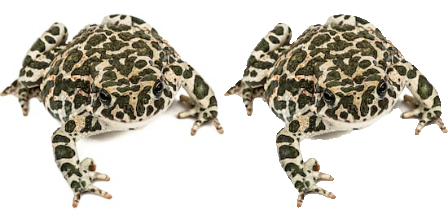

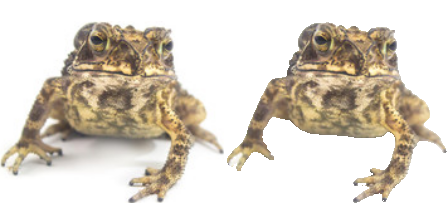

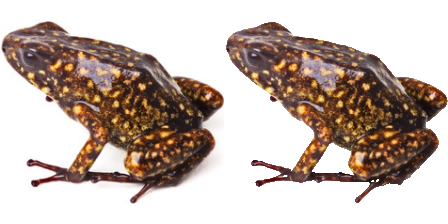

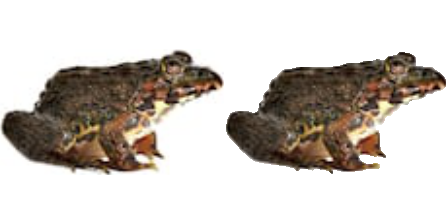

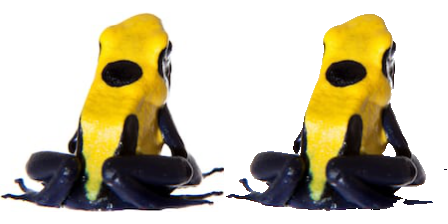

In [72]:
names = [name[:-4] for name in os.listdir(U2_NET_DIR)]
names = random.sample(names, 5)

THRESHOLD = 0.8
RESCALE = 255

for i, name in enumerate(names):

    # BACKGROUND REMOVAL
    if name == '.ipynb_checkpo':
        continue

    # load mask
    output = load_img(U2_NET_DIR / f"{name}.png")
    out_img = img_to_array(output)
    out_img /= RESCALE

    # convert mask to binary (224, 224, 3)
    out_img[out_img > THRESHOLD] = 1
    out_img[out_img <= THRESHOLD] = 0

    # convert to RGBA
    shape = out_img.shape
    # Convert to RGBA
    ## prepare layer of ones - full opacity
    a_layer_init = np.ones(shape=(shape[0], shape[1], 1))
    ## mask is RGB, we only need one channel
    mul_layer = out_img[...,-1:]
    ## mul_layer is 0 for background and 1 for frog
    ## multiply by array of ones to get alpha values for RGBA
    a_layer = mul_layer*a_layer_init
    ## combine RGB+A
    rgba_out = np.append(out_img,a_layer,axis=2)

    # load full image
    input = load_img(IMAGES_DIR / f"{name}.png")
    inp_img = img_to_array(input)
    inp_img /= RESCALE

    # image with removed background
    a_layer = np.ones(shape=(shape[0], shape[1], 1))
    rgba_inp = np.append(inp_img, a_layer,axis=2)
    rem_back = (rgba_inp*rgba_out)
    rem_back_scaled = rem_back*RESCALE
    
    # Output results

    inp_img*=RESCALE
    inp_img = np.append(inp_img,RESCALE*a_layer,axis=2)
    result = np.concatenate((inp_img,rem_back_scaled),axis=1)
    result_img = Img.fromarray(result.astype('uint8'), 'RGBA')
    display(result_img)


# Creating Model Inputs

Use raw image and U2Net output to create a "sketch".

In [109]:
from .src.DexiNed_TF2

# write a function to use the DexiNed model from a jupyter notebook
args = dict(
    
)

model = run_DexiNed(args=args)
model.test()

(224, 224, 1)

## Create small test dataset

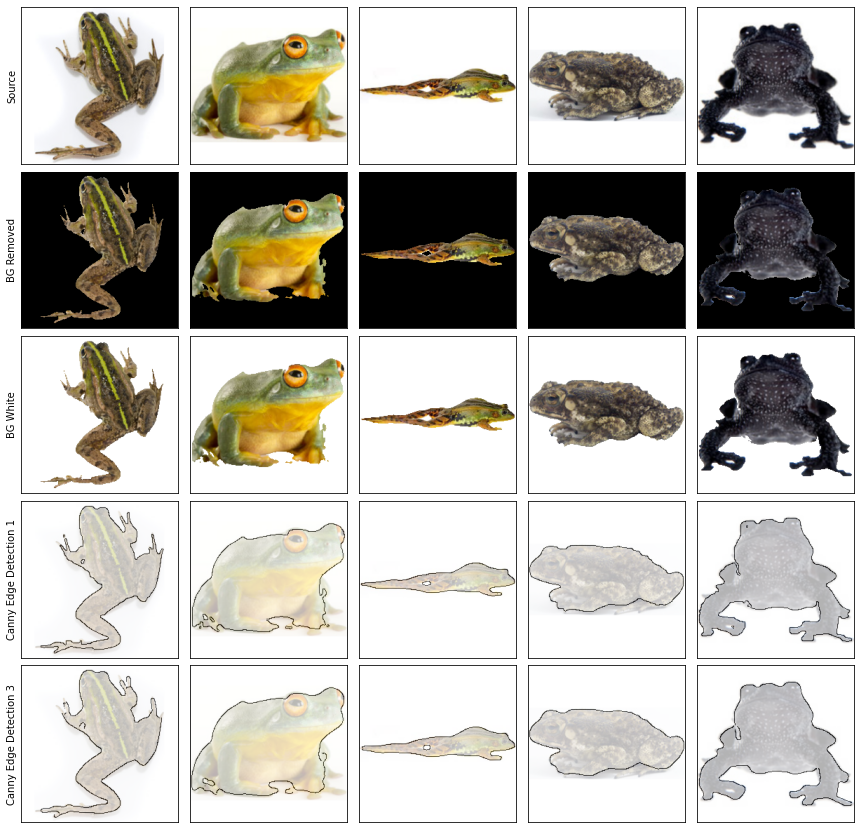

In [121]:
THRESHOLD = 0.9
RESCALE = 255
TO_PLOT = 5
SIZE = 3
ROWS = 5

names = random.sample(list(U2_NET_DIR.glob('*.png')), TO_PLOT)

# prepare figure
fig, axs = plt.subplots(ROWS, TO_PLOT, figsize=(SIZE*TO_PLOT, SIZE*ROWS))

for i, filepath in enumerate(names):

    # load mask
    mask = load_img(filepath)
    mask = img_to_array(mask)
    mask = mask[...,-1:]
    mask /= RESCALE

    # convert mask to binary (224, 224, 1)
    mask[mask > THRESHOLD] = 1
    mask[mask <= THRESHOLD] = 0
    
    # load full image
    image = load_img(IMAGES_DIR / filepath.name)
    image = img_to_array(image)
    image /= RESCALE
    
    # set background to white or black
    image_black_bg = np.where(mask==1, image, np.zeros(image.shape))
    image_white_bg = np.where(mask==1, image, np.ones(image.shape))
    
    # canny edge detection
    edges1 = feature.canny(mask[:,:,0], sigma=1)
    edges2 = feature.canny(mask[:,:,0], sigma=3)
    
    # prepare for display
    axs[0,i].imshow(image)
    axs[1,i].imshow(image_black_bg)
    axs[2,i].imshow(image_white_bg)
    axs[3,i].imshow(edges1, cmap='gray_r')
    axs[3,i].imshow(image, alpha=0.3)
    axs[4,i].imshow(edges2, cmap='gray_r', alpha=1)
    axs[4,i].imshow(image, alpha=0.3)
    
# remove axis ticks
for ax in matplotlib.cbook.flatten(axs):
    ax.set(xticks=[], yticks=[])

# set titles
axs[0,0].set_ylabel('Source')
axs[1,0].set_ylabel('BG Removed')
axs[2,0].set_ylabel('BG White')
axs[3,0].set_ylabel('sigma=1')
axs[4,0].set_ylabel('sigma=3')

# adjust styling and show
fig.patch.set_facecolor('white')      
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()
plt.close()

This is looking much better that the DexiNed "shaded" looking sketches. BUT I suspect this may be even harder to train as there are no eyes or mouths.

The edges cut off parts of the images, this may not be acceptable.

## DexiNed on U2Net

## Canny on outputs of DexiNed